## Step 2: Random Forests
The targets of our analysis are the **maximum generation** reached by a BBH system, and the evolution of the **remnant spin**, since we already know that the remnant mass is $0.9 (M_1 + M_2)$ of the previous generation.

## Maximum generations
First thing first we check if it is possible to predict the maximum generation reached by each BBH from the initial conditions - i.e. from the data of the second generation of each BBH.

To do so we employ the RandomForestClassifier class from the scikit-learn python package. Since we know there are fewer and fewer samples for greater generations, we group together all generations above the third one in a single class. Furthermore, we define a new feature in the dataset called `DV` which is $v_{escape} - v_{kick}$: we know that if the latter is greater than the former the remnant BH is ejected from its cluster, thus being unable to evolve further, hence we expect it to be important.

We begin the analysis with the NSCs, since we know they reach older generations.

In [1]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle, ConnectionPatch
from funky import extractor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, LearningCurveDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay
import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(formatter={'float_kind':"{:.2f}".format})


In [2]:
# Setup dataframes

# columns = ['ID', 'M1', 'M2', 'S1', 'S2', 't_pair', 't_elapsed','kick','Mrem', 'Srem', 'esca_v', 'Mcluster', 'gen', 'Z', 'max_gen', 'DV']
df_gc = extractor('gc')
df_nsc = extractor('nsc')
df_ysc = extractor('ysc')

In [3]:
# Helper function to better define the method's target classes

def classes(gen):
    if gen > 3: return 2
    return gen - 2  # In this way we should be able to correctly cycle through colors later on

In [4]:
# selecting initial conditions and removing undesired features from the dataframe

first_gen = df_nsc[df_nsc['gen'] == 2]
dumped_features = ['ID', 'gen', 'max_gen']

# splitting data in training and test set
x_train, x_test, y_train, y_test = train_test_split((train_feats := first_gen.drop(columns=dumped_features)), first_gen['max_gen'].transform(classes), test_size=0.2)

# Running the RFC algorithm
forest = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=1758, n_jobs=-1, class_weight='balanced')
forest.fit(x_train, y_train)

# Printing results
print('Confusion Matrix\n', ['Max gen 2', 'Max gen 3', 'Max gen above 3'], '\n', confusion_matrix(y_test, forest.predict(x_test)))

Confusion Matrix
 ['Max gen 2', 'Max gen 3', 'Max gen above 3'] 
 [[479228    324     48]
 [     0  20076  11870]
 [     0   1487   2913]]


From the confusion matrix we can clearly appreciate that the forest is almost perfectly able to classify BBHs that stop at the second generation, but it is not so sure about the remaining classes.

By the importance graph below, we infer that the main and practically only interesting feature to do the job is the $v_{escape} - v_{kick}$ feature (hence we may attribute part of the uncertainty to those remnants with a low value of the feature), hinting that is not possible to predict the maximum generation from the initial conditions only.

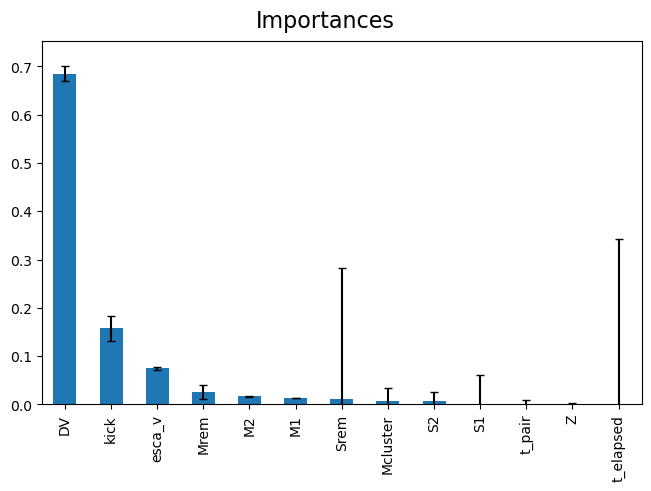

In [5]:
# Plotting importances

fig, ax = plt.subplots(layout='constrained')
fig.suptitle('Importances', fontsize=16)

importances = pd.Series(forest.feature_importances_, index=list(train_feats)).sort_values(ascending=False)
importances.plot.bar(yerr=np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0), capsize=3, ax=ax)
ax.set_ylim(bottom=0)
plt.show()

#### GC & YSC
We expect the model to behave in the same way for GCs and YSCs, so we just run the forest prediction, and calculate the confusion matrix over the corresponding whole datasets.

In [6]:
# GCs

gc_first_gen = df_gc[df_gc['gen'] == 2]
gc_test = gc_first_gen.drop(columns=dumped_features)

print(gc_first_gen.groupby('max_gen').size(), '\n\nConfusion Matrix\n', ['Max gen 2', 'Max gen 3', 'Max gen above 3'])
print(confusion_matrix((target_gc := gc_first_gen['max_gen'].transform(classes)), forest.predict(gc_test)))

max_gen
2    422018
3      5500
4       178
5        15
6         3
dtype: int64 

Confusion Matrix
 ['Max gen 2', 'Max gen 3', 'Max gen above 3']
[[421949     65      4]
 [     0   4180   1320]
 [     0    127     69]]


In [7]:
# YSCs

ysc_first_gen = df_ysc[df_ysc['gen'] == 2]
ysc_test = ysc_first_gen.drop(columns=dumped_features)

print(ysc_first_gen.groupby('max_gen').size(), '\n\nConfusion Matrix\n', ['Max gen 2', 'Max gen 3'])
print(confusion_matrix((target_ysc := ysc_first_gen['max_gen'].transform(classes)), forest.predict(ysc_test)))

max_gen
2    7143
3      32
dtype: int64 

Confusion Matrix
 ['Max gen 2', 'Max gen 3']
[[6221  871   51]
 [   0   31    1]
 [   0    0    0]]


### Decision Boundaries
To visualize the accuracy of the forest we plot the decision boundaries of the two most important features in the feature space calculated by the method, along with the test points. The plot clearly shows the struggle of trying to classify points different from the escaped ones.

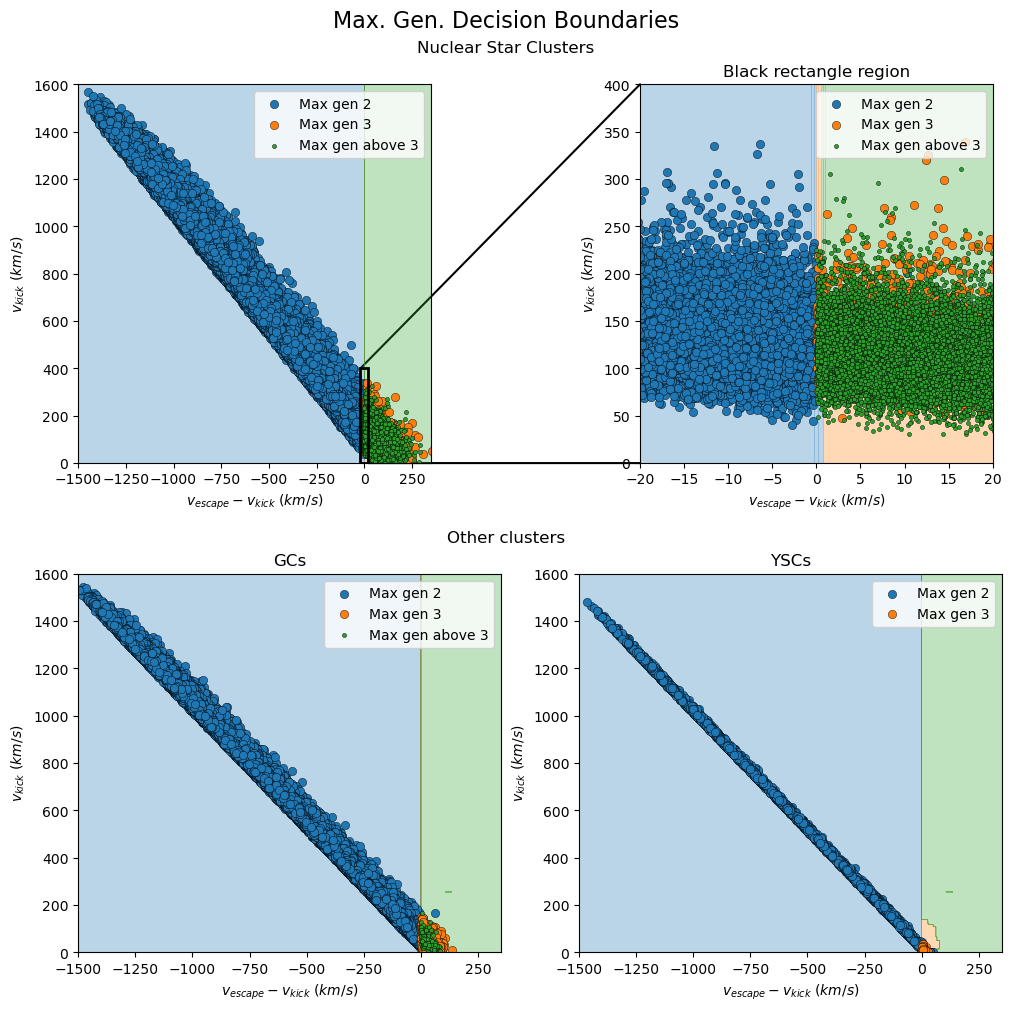

In [8]:
forest.fit(x_train[list(importances.index)[:2]], y_train)
feat_1, feat_2 = np.meshgrid(np.linspace(x_train['DV'].min() - 100, x_train['DV'].max() + 100, 1000), np.linspace(x_train['kick'].min() - 100, x_train['kick'].max() + 100, 1000))
lab = forest.predict(np.c_[feat_1.ravel(), feat_2.ravel()])
lab = lab.reshape(feat_1.shape)


fig = plt.figure(figsize=(10,10), layout='constrained')
fig.suptitle('Max. Gen. Decision Boundaries', fontsize=16)

sfigs = fig.subfigures(2,1)
sfigs[0].suptitle('Nuclear Star Clusters')
sfigs[1].suptitle('Other clusters')

ax0 = sfigs[0].subplots(1,2)
ax1 = sfigs[1].subplots(1,2)

for target, color, label, marker in zip(y_test.unique(), ['tab:blue', 'tab:orange', 'tab:green'], ['Max gen 2', 'Max gen 3', 'Max gen above 3'], ['o', 'o', '.']):
    idx = y_test[y_test == target].index
    ax0[0].scatter(x_test['DV'][idx], x_test['kick'][idx], marker=marker, c=color, edgecolors='k', lw=.3, label=label, zorder=2.02)
    ax0[1].scatter(x_test['DV'][idx], x_test['kick'][idx], marker=marker, c=color, edgecolors='k', lw=.3, label=label, zorder=2.02)

for target, color, label, marker in zip(target_gc.unique(), ['tab:blue', 'tab:orange', 'tab:green'], ['Max gen 2', 'Max gen 3', 'Max gen above 3'], ['o', 'o', '.']):
    idx = target_gc[target_gc == target].index
    ax1[0].scatter(gc_test['DV'][idx], gc_test['kick'][idx], marker=marker, c=color, edgecolors='k', lw=.3, label=label, zorder=2.02)

for target, color, label in zip(target_ysc.unique(), ['tab:blue', 'tab:orange'], ['Max gen 2', 'Max gen 3']):
    idx = target_ysc[target_ysc == target].index
    ax1[1].scatter(ysc_test['DV'][idx], ysc_test['kick'][idx], c=color, edgecolors='k', lw=.3, label=label, zorder=2.02)


ax0[0].add_patch(Rectangle([-20, 0], 40, 400, color='k', lw=2, fill=False, zorder=2.03))
ax0[0].add_patch(ConnectionPatch([-20, 400], [0, 1], 'data', 'axes fraction', axesA=ax0[0], axesB=ax0[1], lw=1.5))
ax0[0].add_patch(ConnectionPatch([20, 0], [0, 0], 'data', 'axes fraction', axesA=ax0[0], axesB=ax0[1], lw=1.5))

ax0[1].set_xlim(-20, 20)
ax0[1].set_ylim(0,400)
ax0[1].set_title('Black rectangle region')

ax1[0].set_title('GCs')
ax1[1].set_title('YSCs')

for i, Ax in enumerate(fig.get_axes()):
    Ax.contourf(feat_1, feat_2, lab, alpha=.3, cmap=ListedColormap(['tab:blue', 'tab:orange', 'tab:green']))
    Ax.set_xlabel('$v_{escape} - v_{kick}$ $(km/s)$')
    Ax.set_ylabel('$v_{kick}$ $(km/s)$')
    Ax.legend(loc='upper right')
    if i != 1:
        Ax.set_xlim(-1500, 350)
        Ax.set_ylim(0, 1600)


plt.show()

### Targeted generation
We expect this behaviour to hold for older generations too, to prove this we run the algorithm over a sample of target generations (for the sake of brevity we only show one of them), and set the objective to its possible evolution.

In [9]:
# data preparation
gen_prec = df_nsc[df_nsc['gen'] == 5]
dumped_features = ['ID', 'gen', 'max_gen']
x_train, x_test, y_train, y_test = train_test_split((train_feats := gen_prec.drop(columns=dumped_features)), gen_prec['max_gen'] > 5, test_size=0.2)

# running forest algorithm
forest = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=1758, n_jobs=-1, class_weight='balanced')
forest.fit(x_train, y_train)
print(f'train size: {len(gen_prec)}\ntest size: {len(y_test)}')
print('Score:', forest.score(x_test, y_test))

train size: 4245
test size: 849
Score: 1.0


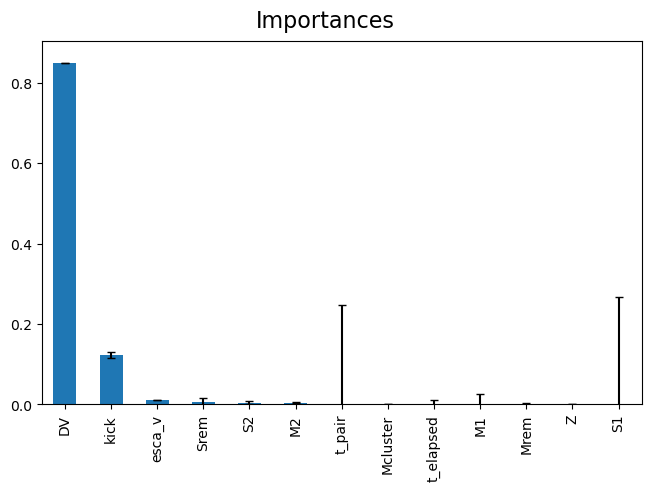

In [10]:
# plot importances

fig, ax = plt.subplots(layout='constrained')
fig.suptitle('Importances', fontsize=16)

importances = pd.Series(forest.feature_importances_, index=list(train_feats)).sort_values(ascending=False)
importances.plot.bar(yerr=np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0), capsize=3, ax=ax)
ax.set_ylim(bottom=0)
plt.show()

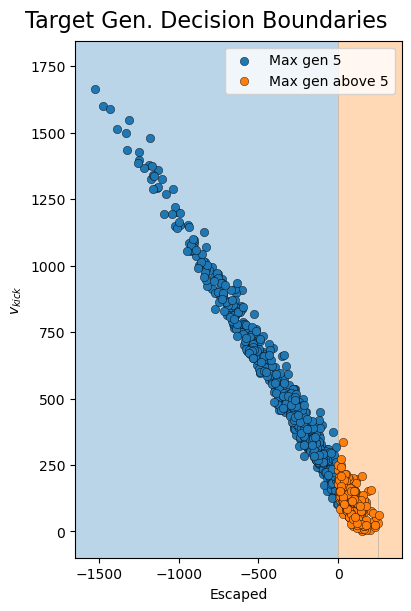

In [11]:
# plot decision boundaries

fig, ax = plt.subplots(figsize=(4,6), layout='constrained')
fig.suptitle('Target Gen. Decision Boundaries', fontsize=16)

forest.fit(x_train[list(importances.index)[:2]], y_train)

feat_1, feat_2 = np.meshgrid(np.linspace(x_train['DV'].min() - 100, x_train['DV'].max() + 100, 1000), np.linspace(x_train['kick'].min() - 100, x_train['kick'].max() + 100, 1000))
lab = forest.predict(np.c_[feat_1.ravel(), feat_2.ravel()])
lab = lab.reshape(feat_1.shape)

ax.contourf(feat_1, feat_2, lab, alpha=.3, cmap=ListedColormap(['tab:blue', 'tab:orange']))
for target, color, label in zip(y_test.unique(), ['tab:blue', 'tab:orange'], ['Max gen 5', 'Max gen above 5']):
    idx = y_test[y_test == target].index
    ax.scatter(x_test['DV'][idx], x_test['kick'][idx], c=color, edgecolors='k', lw=.3, label=label, zorder=2.02)



ax.set_ylabel('$v_{kick}$')
ax.set_xlabel('Escaped')
ax.legend()
plt.show()

## Spin of the Remnant
Since the spin of the remnant is a continuous features, we implement the RandomForestRegressor class instead.

In [12]:
dumped_features = ['ID', 'Srem', 'max_gen', 'DV', 'Mrem']

x_train, x_test, y_train, y_test = train_test_split((train_feats := df_nsc.drop(columns=dumped_features)), df_nsc['Srem'], test_size=0.2)

forest = RandomForestRegressor(n_estimators=10, max_depth=15, random_state=1758, n_jobs=-1)
forest.fit(x_train, y_train)
print(f'train size: {len(y_train)}\ntest size: {len(y_test)}')
print('Score over the test set:', forest.score(x_test, y_test))
print('Score over the GC data:', forest.score(df_gc.drop(columns=dumped_features), df_gc['Srem']))
print('Score over the YSC data:', forest.score(df_ysc.drop(columns=dumped_features), df_ysc['Srem']))

train size: 2230650
test size: 557663
Score over the test set: 0.9778546401962043
Score over the GC data: 0.9716854125990187
Score over the YSC data: 0.972944446281406


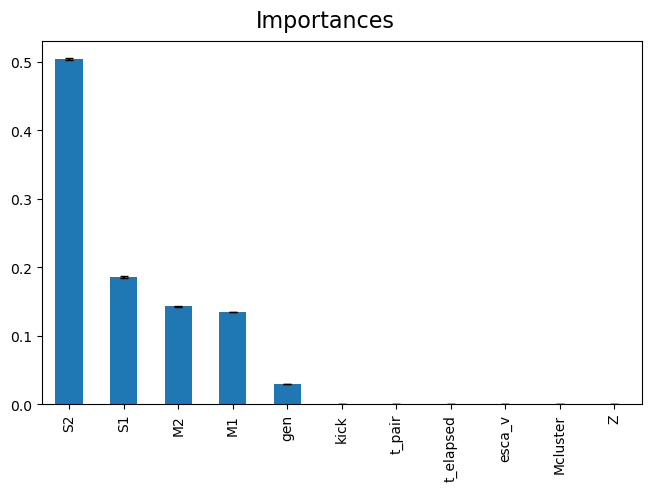

In [13]:
fig, ax = plt.subplots(layout='constrained')
fig.suptitle('Importances', fontsize=16)

importances = pd.Series(forest.feature_importances_, index=list(train_feats)).sort_values(ascending=False)
importances.plot.bar(yerr=np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0), capsize=3, ax=ax)
ax.set_ylim(bottom=0)
plt.show()

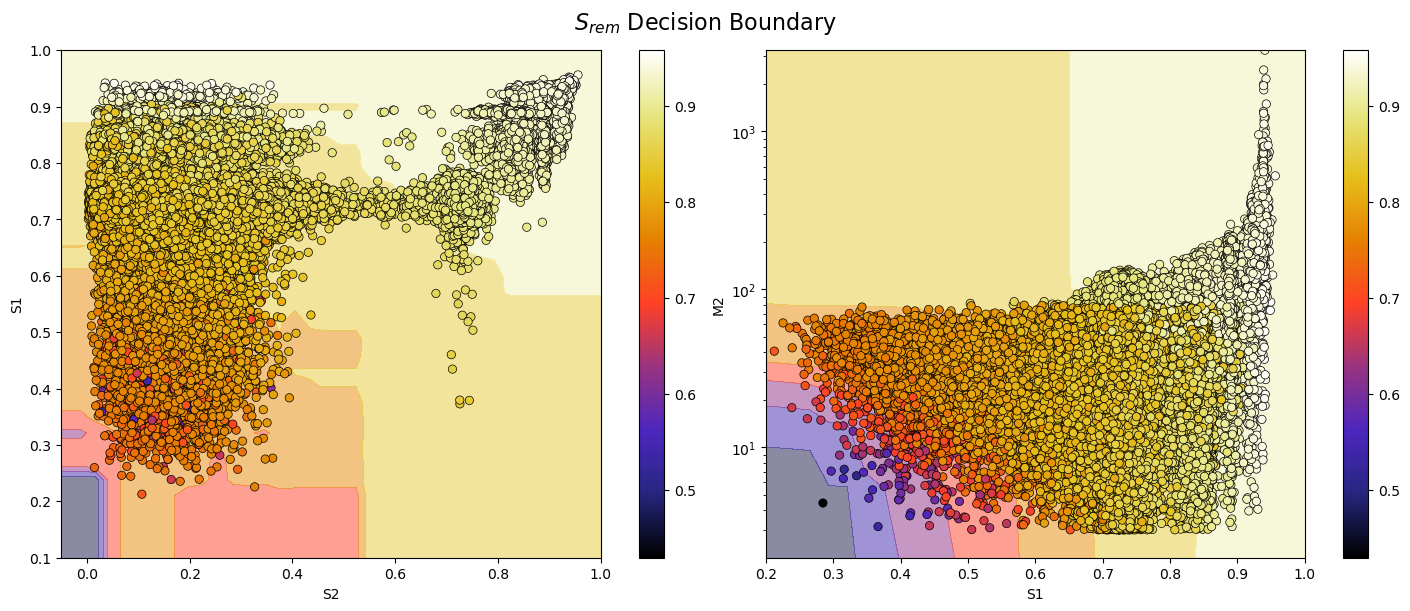

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(14,6), layout='constrained')
fig.suptitle('$S_{rem}$ Decision Boundary', fontsize=16)


forest.fit(x_train[( important_features := list(importances.index[:2]) )], y_train)
display = DecisionBoundaryDisplay.from_estimator(forest, x_test[important_features], response_method="predict", alpha=.5, cmap='CMRmap', ax=ax[0])

im = display.ax_.scatter(x_test[important_features[0]], x_test[important_features[1]], edgecolor='k', c=y_test, lw=.5, cmap='CMRmap')
ax[0].set_xlim(-.05, 1)
ax[0].set_ylim(0.1, 1)
fig.colorbar(im)


forest.fit(x_train[( important_features := list(importances.index[[1,2]]) )], y_train)
display = DecisionBoundaryDisplay.from_estimator(forest, x_test[important_features], response_method="predict", alpha=.5, cmap='CMRmap', ax=ax[1])

im = display.ax_.scatter(x_test[important_features[0]], x_test[important_features[1]], edgecolor='k', c=y_test, lw=.5, cmap='CMRmap')
ax[1].set_yscale('log')
ax[1].set_xlim(.2, 1)
fig.colorbar(im)

plt.show()